# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
%matplotlib inline

from sklearn.cluster import AgglomerativeClustering
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import kruskal

pd.options.mode.chained_assignment = None # disable SettingWithCopyWarning
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')

# Loading and adjusting the dataset

In [2]:
df = pd.read_csv('data_files/PCNSL_imputed_cleared.csv')

df['LocDeep'] = np.sum(df[['LocSubcortical', 'LocOther', 'LocBrainstem', 'LocCerebellum']], axis=1)

columnname_mapping = {'VolEnhancing':'Enhancing volume', 
                      'VolNecrosis':'Necrotic volume', 
                      'VolEdema':'Edema volume',
                      'LocDeep':'Deep location', 
                      'LocBrainstem':'Brainstem location', 
                      'NumberFoci':'Number of foci', 
                      'Methotrexat':'Methotrexate', 
                      'HD-Methotrexat':'HD-Methotrexate', 
                      'Poly-CT':'Poly-chemotherapy', 
                      'First-Line_CT':'Chemotherapy', 
                      'First-Line_CT-RT':'Chemoradiotherapy', 
                      'First-Line_RT':'Radiotherapy',
                      'LocCerebellum':'Cerebellar location'}
df.columns = df.columns.map(lambda s: columnname_mapping[s] if s in columnname_mapping else s)

features_perc = ['LocPercLeft', 'LocFrontal', 'LocTemporal', 'LocParietal', 'LocOccipital', 'LocSubcortical', 'LocOther', 'Deep location',  'Brainstem location',  'Cerebellar location',  'CD3',  'CD45ro',  'CD68',  'FoxP3']
df[features_perc] = df[features_perc].mul(100)

In [3]:
df.head()

,Unnamed: 0,Sex,Age,Enhancing volume,Necrotic volume,Edema volume,LocPercLeft,Cerebellar location,LocFrontal,LocTemporal,...,Poly-chemotherapy,ECOG,Immunodeficiency,CD3,CD45ro,CD68,FoxP3,followup,deceased,Deep location
0,0,male,81.0,20.15,0.00,114.83,3.0,3.0,2.0,77.0,...,0.0,1.0,0.0,10.680529,36.752675,31.310096,0.981997,91.0,1.0,17.0
1,1,male,40.0,6.11,0.00,43.11,0.0,3.0,0.0,6.0,...,1.0,2.0,0.0,7.385868,16.613026,7.792904,0.465340,143.0,1.0,93.0
2,2,female,70.0,13.88,0.07,165.49,9.0,0.0,0.0,64.0,...,1.0,1.0,0.0,5.347836,14.519470,22.862823,0.624073,280.0,1.0,23.0
3,3,male,71.0,4.96,0.00,26.70,19.0,0.0,0.0,0.0,...,1.0,2.0,0.0,60.653805,77.875079,44.261093,4.502919,161.0,1.0,97.0
4,4,male,27.0,18.99,0.00,148.48,100.0,0.0,25.0,0.0,...,0.0,1.0,0.0,68.724571,75.394495,20.807754,7.343329,3279.0,0.0,75.0


In [4]:
df.columns

Index(['Unnamed: 0', 'Sex', 'Age', 'Enhancing volume', 'Necrotic volume',
       'Edema volume', 'LocPercLeft', 'Cerebellar location', 'LocFrontal',
       'LocTemporal', 'LocParietal', 'LocOccipital', 'LocSubcortical',
       'Brainstem location', 'LocOther', 'Number of foci', 'First-Line_BSC',
       'Radiotherapy', 'Chemotherapy', 'Chemoradiotherapy', 'Methotrexate',
       'HD-Methotrexate', 'Rituximab', 'Poly-chemotherapy', 'ECOG',
       'Immunodeficiency', 'CD3', 'CD45ro', 'CD68', 'FoxP3', 'followup',
       'deceased', 'Deep location'],
      dtype='object')

# Defining the clustering and helper functions

In [5]:
def clustering(data, sex='both', cluster_features=None, n_clusters=4, random_state=11, annotate=('cluster', 'sex', 'therapy'), 
               cluster_names=None, cluster_colors=None):    

    affinity='euclidean'
    linkage='ward'
    vmin = -2.5
    vmax = 2.5
    cmap='coolwarm'
    format_dict = {-2: '-2 std', 0: 'Mean', 2: '+2 std'}
    formatter = mpl.ticker.FuncFormatter(lambda x, pos: format_dict[x])
    cbar_kws={'ticks': [-2, 0, 2], 'format':formatter, 'use_gridspec':False}
    
    if sex=='male':
        data = data[data.Sex=='male']
    elif sex=='female':
        data = data[data.Sex=='female']
            
    x_train = data.copy()
    
    x_train.loc[:, cluster_features] = StandardScaler().fit_transform(x_train.loc[:, cluster_features])

    model = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
    model.fit(x_train.loc[:,cluster_features])
    
    model_labels = pd.Series(model.labels_)
    if not cluster_names==None:
        model_labels = model_labels.map(cluster_names)
    
    ###### -------------- CLUSTERING -------------------------------------------
    d = x_train.copy()
    
    annotations = []
    # Cluster
    if 'cluster' in annotate:
        labels_unique = pd.Series(model_labels).dropna().unique()
        if not cluster_colors: cluster_colors = dict(zip(labels_unique, sns.color_palette("Dark2", len(labels_unique))))
        cluster_labels = pd.Series(model_labels).map(cluster_colors)
        cluster_labels.name = 'Cluster'
        legend_cluster = [mpatches.Patch(color=c, label=l) for l,c in sorted(cluster_colors.items())]
        annotations.append(cluster_labels)
        
    # Sex
    if 'sex' in annotate:
        sex_colors = sns.husl_palette(2, l=.7, s=.8)
        sex_labeling = {'female': sex_colors[0], 'male': sex_colors[1]}
        sex_labels = pd.Series(df.Sex.map(sex_labeling).values, name = 'Sex')
        legend_sex = [mpatches.Patch(color=c, label=l) for l,c in sex_labeling.items()]
        annotations.append(sex_labels)

    # Therapy
    if 'therapy' in annotate:       
        therapy_values = pd.Series(x_train['Radiotherapy'] + 2*x_train['Chemotherapy'] + 3*x_train['Chemoradiotherapy'])
        therapy_unique_labels = ['BSC', 'RT', 'CT', 'CT+RT']
        therapy_unique = np.sort(therapy_values.unique())
        therapy_colors = sns.color_palette('Purples', 4)
        therapy_colormapping = dict(zip(therapy_unique, therapy_colors))
        therapy_labels = pd.Series(therapy_values.map(therapy_colormapping), name='Therapy').reset_index(drop=True)
        legend_therapy = [mpatches.Patch(color=c, label=l) for l,c in zip(therapy_unique_labels, therapy_colors)]
        annotations.append(therapy_labels)
    
    # Set row colors
    row_colors = pd.concat(annotations, axis='columns')    

    ####### Build the clustermap
    x = x_train.loc[:, cluster_features].reset_index(drop=True)             
    
    g = sns.clustermap(x, xticklabels = x_train[cluster_features].columns, method=linkage, metric=affinity, cmap=cmap, row_colors=row_colors, vmin=vmin, vmax=vmax,
                      cbar_kws=cbar_kws,
                      yticklabels=False)
    cax = g.cax
    cax_bbox=cax.get_position()
    cax_bbox.x0 += 0.97
    cax_bbox.x1 += 0.97
    cax_bbox.y0 += .05
    cax_bbox.y1 += .05
    cax.set_position(cax_bbox)
    
    ax_rc = g.ax_row_colors
    ax_rc.tick_params(axis='x', direction='in', labelsize=12)
    
    ax = g.ax_heatmap
    
    if 'cluster' in annotate:
        l2=ax.legend(loc='upper left', bbox_to_anchor=(1, 1), handles=legend_cluster, frameon=True)
        l2.set_title('Cluster')
        ax.add_artist(l2)

    if 'sex' in annotate:
        l_sex=g.ax_heatmap.legend(loc='upper left', bbox_to_anchor=(1, 0.6), handles=legend_sex, frameon=True)
        l_sex.set_title('Sex')
        ax.add_artist(l_sex)
        
    if 'therapy' in annotate:
        l_therapy = g.ax_heatmap.legend(loc='upper left', bbox_to_anchor=(1, 0.4), handles=legend_therapy, frameon=True)
        l_therapy.set_title('Therapy')
    
        
    # ----------------------------- return --------------
    return model, model_labels

In [6]:
def anova_by_cluster(variable, df, groupby):
    samples = [df.loc[df[groupby]==cluster, variable].values for cluster in df[groupby].dropna().unique()]
    _, pvalue = f_oneway(*samples)
    return pvalue

def kruskal_by_cluster(variable, df, groupby):
    samples = [df.loc[df[groupby]==cluster, variable].values for cluster in df[groupby].dropna().unique()]
    _, pvalue = kruskal(*samples)
    return pvalue

def comparison_table(df, groupby, features):
    
    features = list(set(features) - set(['ECOG', 'Number of foci', 'Immunodeficiency']))
    
    ordinal_columns = ['ECOG', 'Number of foci']
    pvals_ordinals = [kruskal_by_cluster(variable, df, groupby) for variable in ordinal_columns]
    ordinals = (df.groupby(groupby)[ordinal_columns].agg(lambda x: str(np.median(x).astype(int)) + ' (' + str(np.percentile(x, 25).astype(int)) + '-' + str(np.percentile(x,75).astype(int)) + ')')).transpose()
    ordinals['p-value'] = [str(np.round(pval, 2)) if pval >= 0.01 else '<0.01' for pval in pvals_ordinals]
    
    crosstab = pd.crosstab(df['Immunodeficiency'], df[groupby])
    _, pval_immunodef, _, _ = chi2_contingency(crosstab)
    immunodef = pd.DataFrame(df.groupby(groupby)['Immunodeficiency'].agg(lambda x: str(int(np.sum(x))) + ' (' + str(np.round(np.mean(x)*100, 1)) + '%)')).transpose()
    immunodef['p-value'] = str(np.round(pval_immunodef, 2)) if pval_immunodef >= 0.01 else '<0.01'
    
    units = {'Age': 'yrs', 
      'Enhancing volume': 'cm³', 
      'Necrotic volume': 'cm³', 
      'Edema volume': 'cm³', 
      'Left location': '%', 
      'Right location': '%',
      'Cerebellar location': '%', 
      'Frontal location': '%', 
      'Temporal location': '%',
      'Parietal location': '%',
      'Occipital location': '%',
      'Subcortical location': '%',
      'Deep location': '%',
      'Brainstem location': '%',
      'Other location': '%',
      'CD3': '%',
      'CD45ro': '%',
      'CD68': '%',
      'FoxP3': '%'}
    
    
    numeric = df.groupby(groupby)[features].agg(lambda x: str(np.round(np.mean(x), 1)) + ' ±' + str(np.round(np.std(x), 1)) + units[x.name]).transpose()
    pvals = [anova_by_cluster(variable, df, groupby) for variable in features] 
    numeric['p-value'] = [str(np.round(pval, 2)) if pval >= 0.01 else '<0.01' for pval in pvals]
    
    bcluster_comparisons = pd.concat([numeric, ordinals, immunodef])
    
    bcluster_comparisons.columns = bcluster_comparisons.columns.str.replace('\n', ' ')
    
    return bcluster_comparisons

def comparison_figure(df, groupby, features_list, ylabels, palette):
    # Here, features_list should be a list of lists, depeding on the units of the features
  
    fig, axes = plt.subplots(ncols=len(features_list), figsize=(8,6), gridspec_kw=dict(wspace=.5, top=0.91))
    
    for i, features in enumerate(features_list):
             
        ax = axes[i]
        
        df_melted = pd.melt(df,
                 id_vars=[groupby],
                 value_vars=features, 
                 var_name='Feature')
        
        
        sns.boxplot(x='Feature',
                   y='value',
                   hue=groupby,
                   palette=palette,
                   ax=ax,
                   data=df_melted)       
        
        ax.get_legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel(ylabels[i], rotation='horizontal', ha='left')
        ax.yaxis.set_label_coords(-0.3,1)

    
    fig.suptitle('Cluster-defining features', y=1, fontsize=20)

# Clustering

In [7]:
cluster_features = ['Age', 'Enhancing volume', 'Necrotic volume', 'Edema volume', \
            'Deep location', 'Number of foci', 'ECOG', 'CD3', 'CD45ro', 'CD68', 'FoxP3', ]

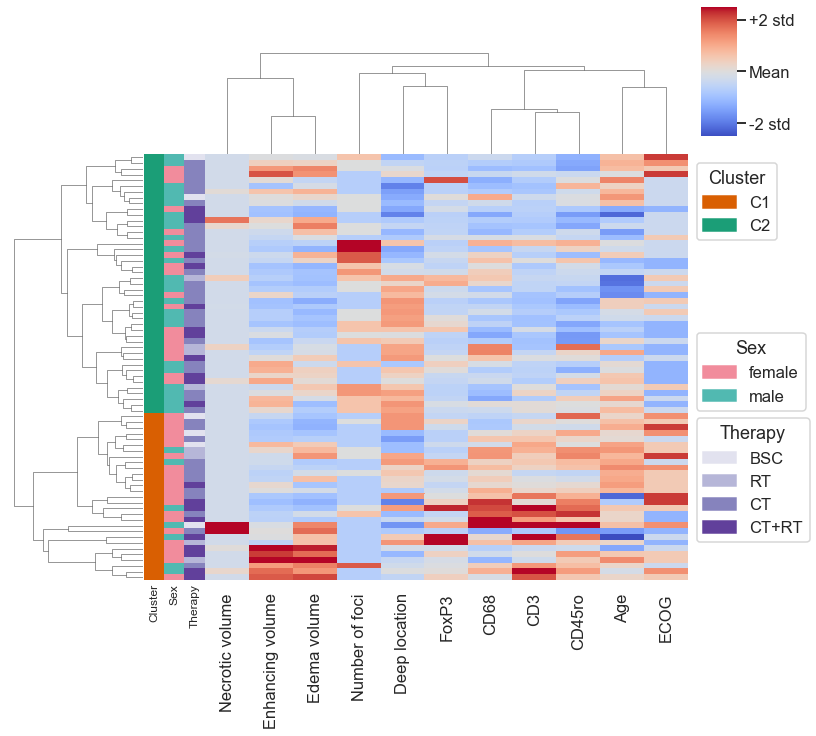

In [8]:
_, model_labels = clustering(df, cluster_features=cluster_features, n_clusters=2,
            cluster_names={0:'C1', 1:'C2'},
            annotate=['cluster', 'sex', 'therapy'])
df.loc[:,'Cluster_all'] = model_labels.tolist()

Cluster_all                   C1             C2 p-value
Necrotic volume      0.9 ±3.0cm³    0.2 ±0.6cm³    0.16
Edema volume      119.7 ±92.3cm³  82.7 ±58.1cm³    0.04
CD3                  28.0 ±17.6%      7.0 ±6.0%   <0.01
CD68                 25.2 ±13.9%     14.2 ±9.1%   <0.01
CD45ro               54.6 ±20.3%    27.1 ±16.9%   <0.01
Age                67.1 ±14.2yrs  60.8 ±13.2yrs    0.06
FoxP3                  1.5 ±2.1%      0.6 ±0.8%    0.01
Enhancing volume   24.0 ±25.9cm³  17.0 ±13.9cm³    0.14
Deep location        57.1 ±31.6%    60.0 ±31.7%    0.71
ECOG                     2 (1-3)        1 (0-1)   <0.01
Number of foci           1 (1-1)        2 (1-3)   <0.01
Immunodeficiency       3 (10.3%)       4 (8.9%)    0.84


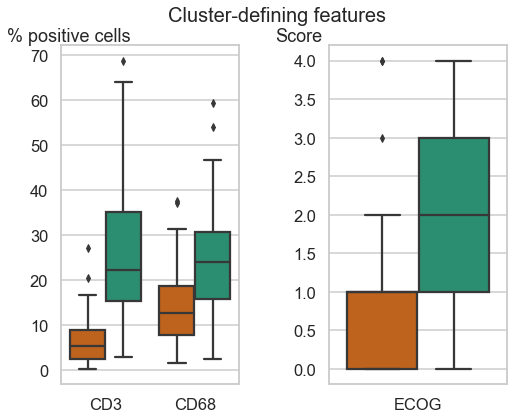

In [9]:
palette = sns.color_palette("Dark2", 2) 
palette={'C1': palette[0], 'C2': palette[1]}

print(comparison_table(df, 'Cluster_all', cluster_features))
comparison_figure(df, 'Cluster_all', [['CD3', 'CD68'], ['ECOG']], ['% positive cells', 'Score'], palette)

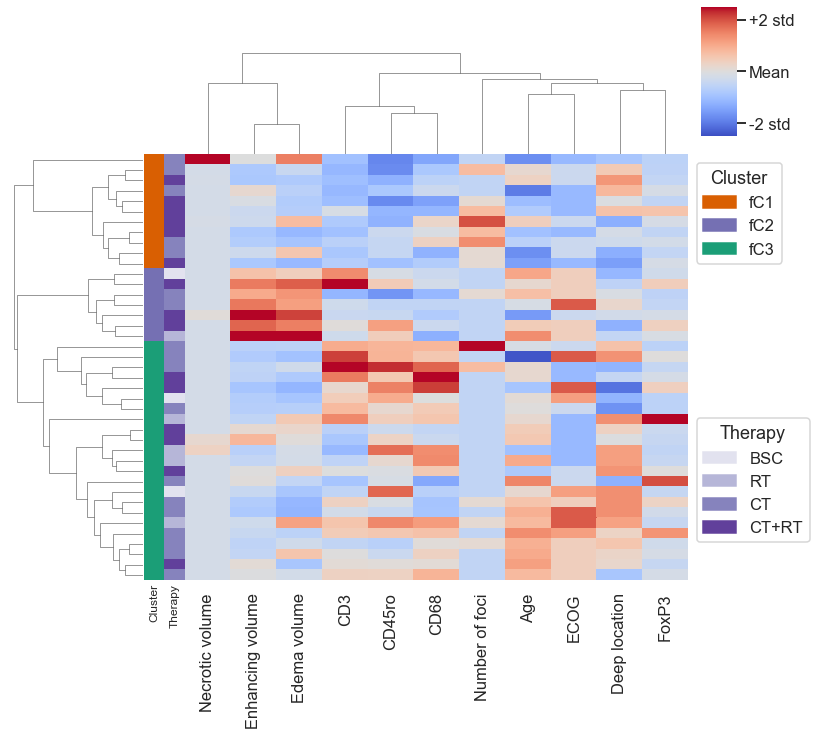

In [10]:
palette = sns.color_palette("Dark2", 3)
palette={'fC3': palette[0], 'fC1': palette[1], 'fC2': palette[2]}

_, model_labels = clustering(df, sex='female', cluster_features=cluster_features, n_clusters=3,
            cluster_names={0: 'fC1', 1:'fC3', 2:'fC2'},
            cluster_colors=palette,
            annotate=['cluster', 'therapy'])
df.loc[df.Sex=='female','Cluster_female'] = model_labels.tolist()

Cluster_female              fC1             fC2            fC3 p-value
Necrotic volume     1.3 ±4.0cm³     0.1 ±0.2cm³    0.1 ±0.3cm³    0.31
Edema volume      77.1 ±68.7cm³  233.1 ±56.8cm³  73.0 ±49.8cm³   <0.01
CD3                   4.3 ±3.4%     18.1 ±14.5%    18.4 ±11.7%   <0.01
CD68                 11.6 ±7.6%      11.8 ±4.7%    25.8 ±12.4%   <0.01
CD45ro              17.1 ±11.3%     38.7 ±17.7%    51.7 ±16.6%   <0.01
Age               53.5 ±10.7yrs   68.7 ±11.9yrs  68.6 ±11.6yrs   <0.01
FoxP3                 0.4 ±0.5%       0.7 ±0.5%      1.1 ±2.0%     0.5
Enhancing volume   10.6 ±8.2cm³   64.9 ±22.0cm³   12.0 ±9.2cm³   <0.01
Deep location       54.3 ±26.2%     45.3 ±14.2%    66.7 ±31.8%     0.2
ECOG                    0 (0-1)         2 (2-2)        2 (0-3)   <0.01
Number of foci          2 (1-3)         1 (1-1)        1 (1-1)   <0.01
Immunodeficiency       0 (0.0%)        0 (0.0%)      3 (13.0%)    0.28


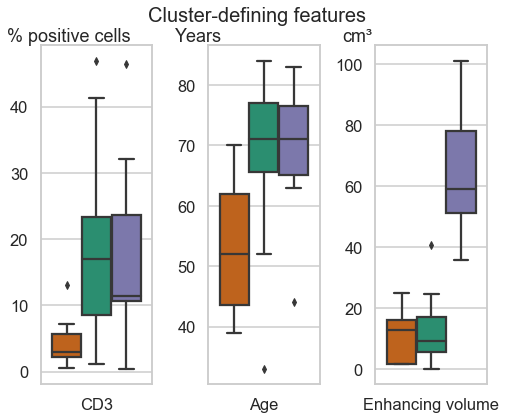

In [11]:
print(comparison_table(df, 'Cluster_female', cluster_features))
comparison_figure(df, 'Cluster_female', [['CD3'], ['Age'], ['Enhancing volume']], ['% positive cells', 'Years', 'cm³'], palette)

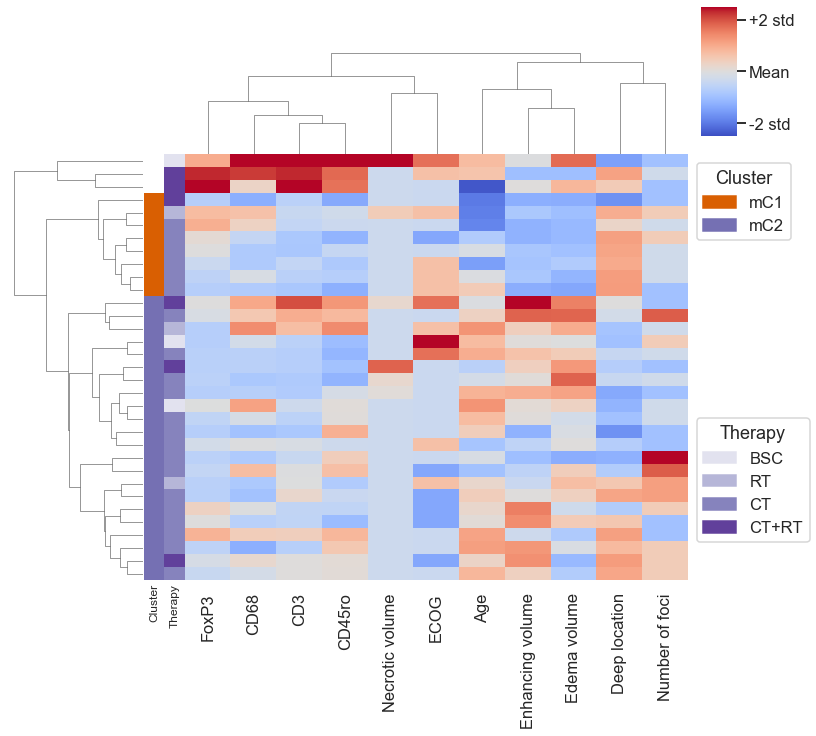

In [12]:
palette = sns.color_palette("Dark2", 3)
palette = {'mC1': palette[1], 'mC2': palette[2]}

_, model_labels = clustering(df, sex='male', cluster_features=cluster_features, n_clusters=3,
            cluster_names={2:'mC1', 1:'mC2'},
            cluster_colors=palette,          
            annotate=['cluster', 'therapy'])
df.loc[df.Sex=='male','Cluster_male'] = model_labels.tolist()

Cluster_male                mC1             mC2 p-value
Necrotic volume     0.2 ±0.5cm³     0.3 ±0.8cm³    0.73
Edema volume      20.7 ±12.3cm³  113.0 ±56.8cm³   <0.01
CD3                   4.3 ±3.3%     13.7 ±12.8%    0.06
CD68                 12.5 ±7.4%      15.5 ±9.1%    0.42
CD45ro               16.6 ±9.7%     35.0 ±18.8%    0.02
Age               47.9 ±13.3yrs    67.4 ±9.5yrs   <0.01
FoxP3                 0.9 ±0.9%       0.5 ±0.6%    0.15
Enhancing volume    4.1 ±2.7cm³   24.4 ±12.9cm³   <0.01
Deep location       80.8 ±32.0%     49.4 ±30.8%    0.03
ECOG                    1 (1-2)         1 (1-1)    0.42
Number of foci          2 (1-2)         2 (1-3)     0.5
Immunodeficiency      1 (12.5%)        2 (9.1%)    0.68


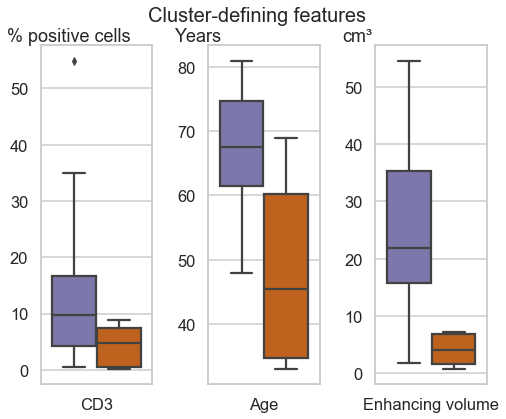

In [13]:
print(comparison_table(df, 'Cluster_male', cluster_features))
comparison_figure(df, 'Cluster_male', [['CD3'], ['Age'], ['Enhancing volume']], ['% positive cells', 'Years', 'cm³'], palette)